<a href="https://colab.research.google.com/github/hdjcool/AI-study-DL/blob/master/HDR_STM32L4_IoTNode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
title:  "Human Activity Recognition on STM32L4 IoTnode"
excerpt: “HAR tensorflow on B-L475E-IOT01A02”
header:
  teaser: /assets/images/HAR_01.png

categories:
  - DL
tags:
  - python
  - tensorflow
  - HAR
  - classification
---

# Human Activity Recognition on STM32L4 IoTnode
직장인이자 인공지능을 공부하는 대학원생으로 지금까지 머신러닝이나 딥러닝을 PC 기반 python 에서 지원하는 플랫폼에서 모델들에 대해 이론과 실습 예제들을 공부 해왔는데 Edge AI 기반의 임베디드 디바이스에서 돌아가는 project 를 해보고 싶었고 일단 접하기 쉬운 STMicroelectronics 사의 B-L475E-IOT01A02 개발보드를 좀 가지고 놀아 볼려고 내돈내산 해서 구매 하였다.

* B-L475E-IOT01A Link: <https://www.st.com/content/st_com/en/products/evaluation-tools/product-evaluation-tools/mcu-mpu-eval-tools/stm32-mcu-mpu-eval-tools/stm32-discovery-kits/b-l475e-iot01a.save-bookmark.html>

우선 HAR 을 구현하기 위해 ST 의 예제를 따라 구현 하였으며 아래는 이에 관한 설명에 관한 내용이다.
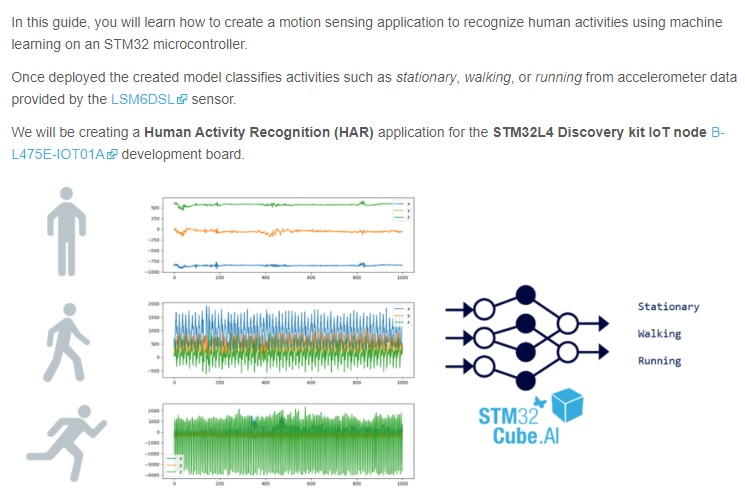

## Requirements
- B-L475E-IOT01A: STM32L4 Discovery kit IoT node.
- STM32CubeIDE v1.6.0 or later (tested on latest v1.10.0), with:

    X-CUBE-MEMS1 v8.3.0 or later (tested on latest 9.2.0) - for motion sensor component drivers.
    
    X-CUBE-AI v7.1.0 or later (tested on latest 7.2.0) - for the neural network conversion tool & network runtime library.
- A serial terminal application (such as Tera Term, PuTTY, GNU Screen or others).
- A Keras model : pre-trained model.h5 or create your own model using your own data captures.

참고 : Human Activity Recognition.jpynb 를 colab 환경에서 실행 시켜 제공된 dataset 으로 학습 후 model.h5 를 생성 하였지만 MCU 코드로 add 시키는 과정에서 analyze 에서 keras 버전이 맞지 않아 기존 model.h5 를 사용함 

### Create a new project
- STM32CubeIDE 에서 File > New > STM32 Project.
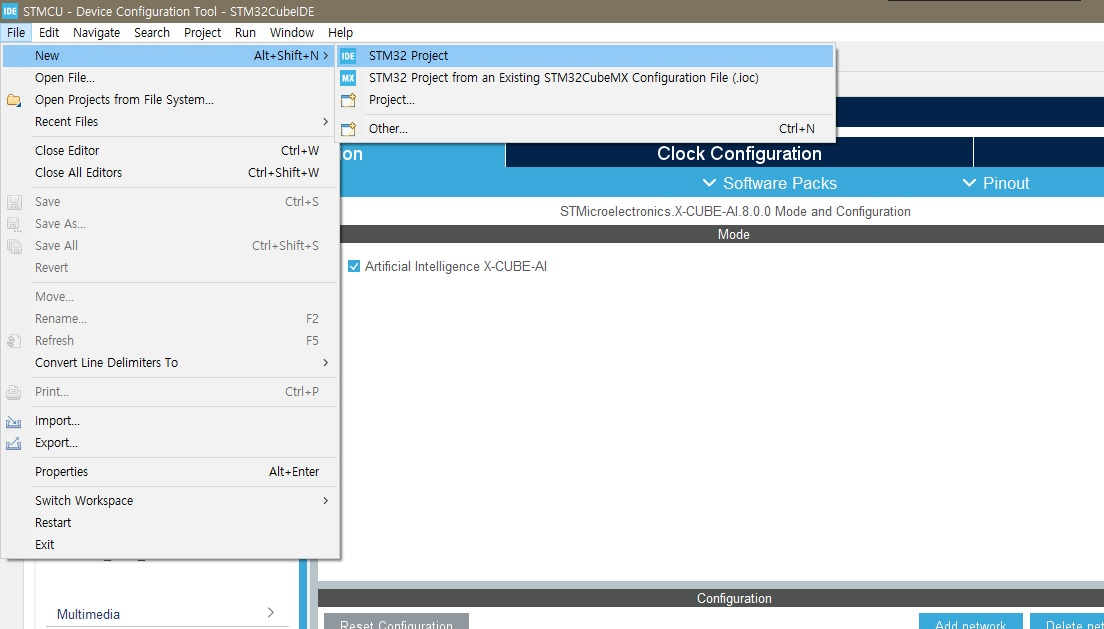


Select your board

**참고 : When prompted to initialize all peripherals with their default mode, select No to avoid generating unused code.**

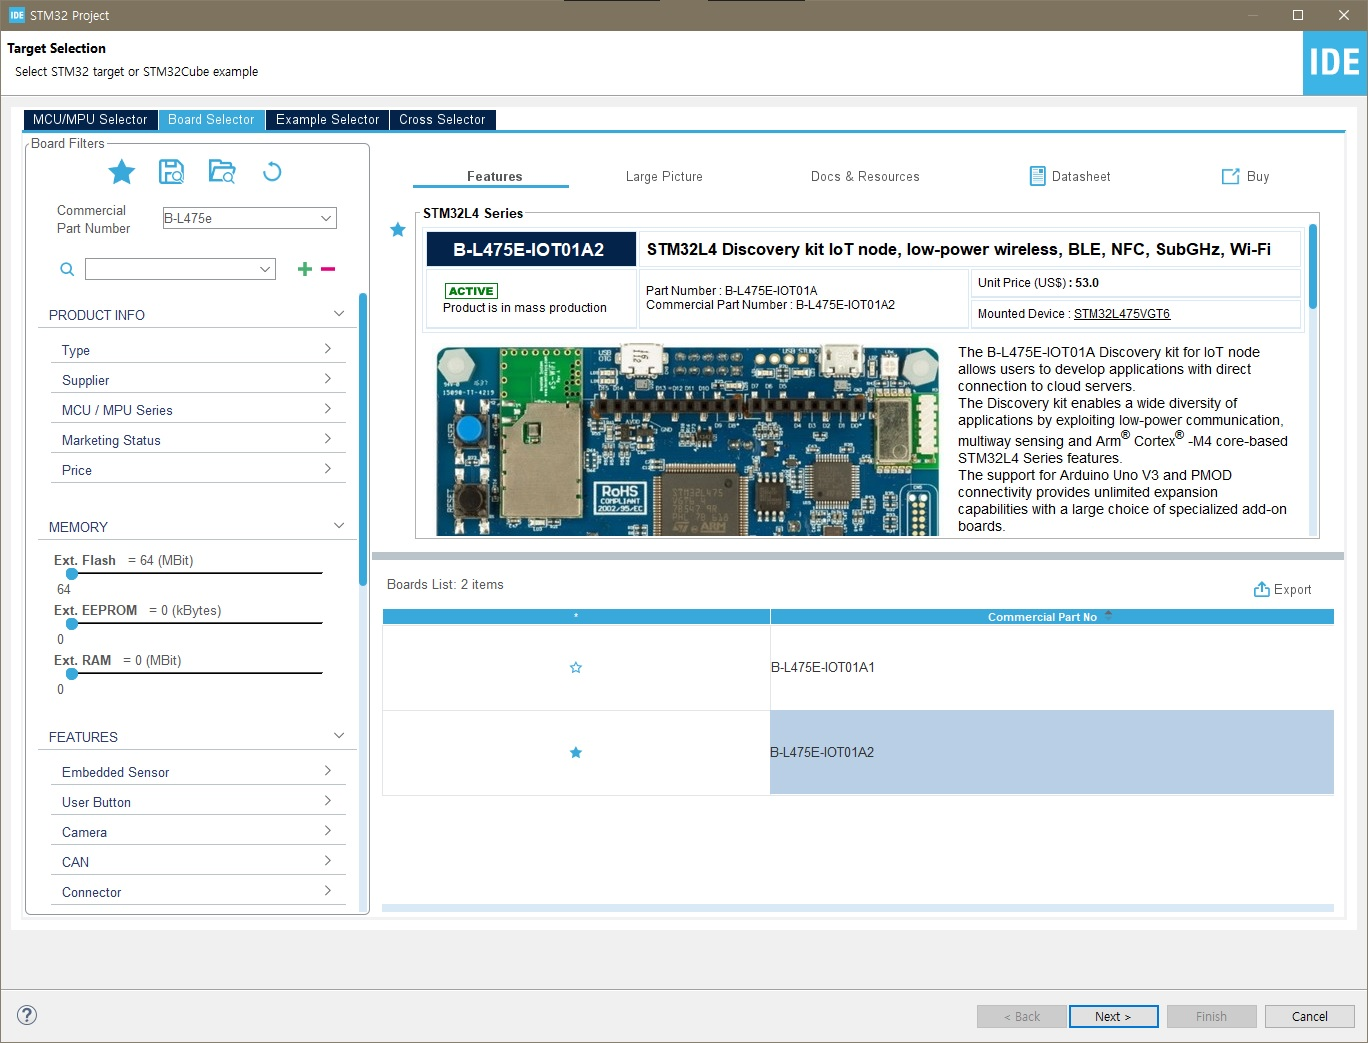


Add the LSM6DSL sensor driver from X-CUBE-MEMS Components

Software Packs > Select Components

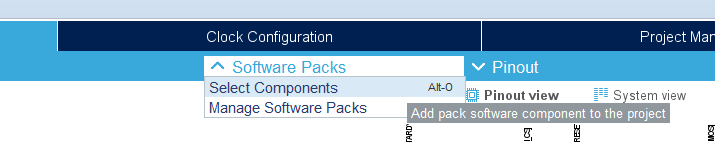

Select the LSM6DSL intertial module with an I2C interface.

Board Part -> LSM6DSL I2C 선택
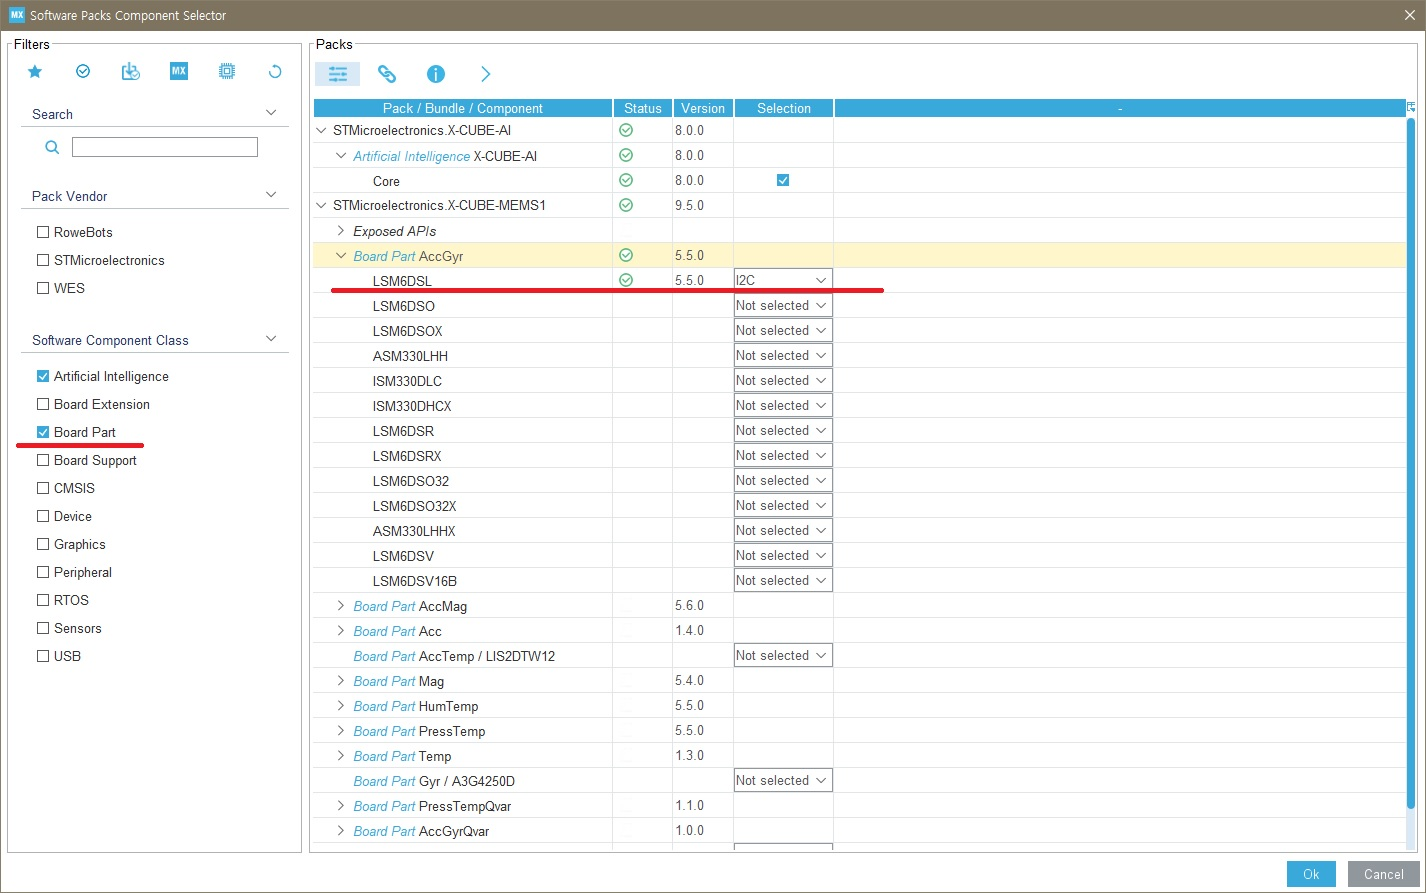

Configure the I2C bus interface

I2C2 -> I2C -> Fast Mode & 400 Khz(LSM6DSL maximum I2C clock frequency) 설정
PB10 and PB11 pins I2C2 interface 확인
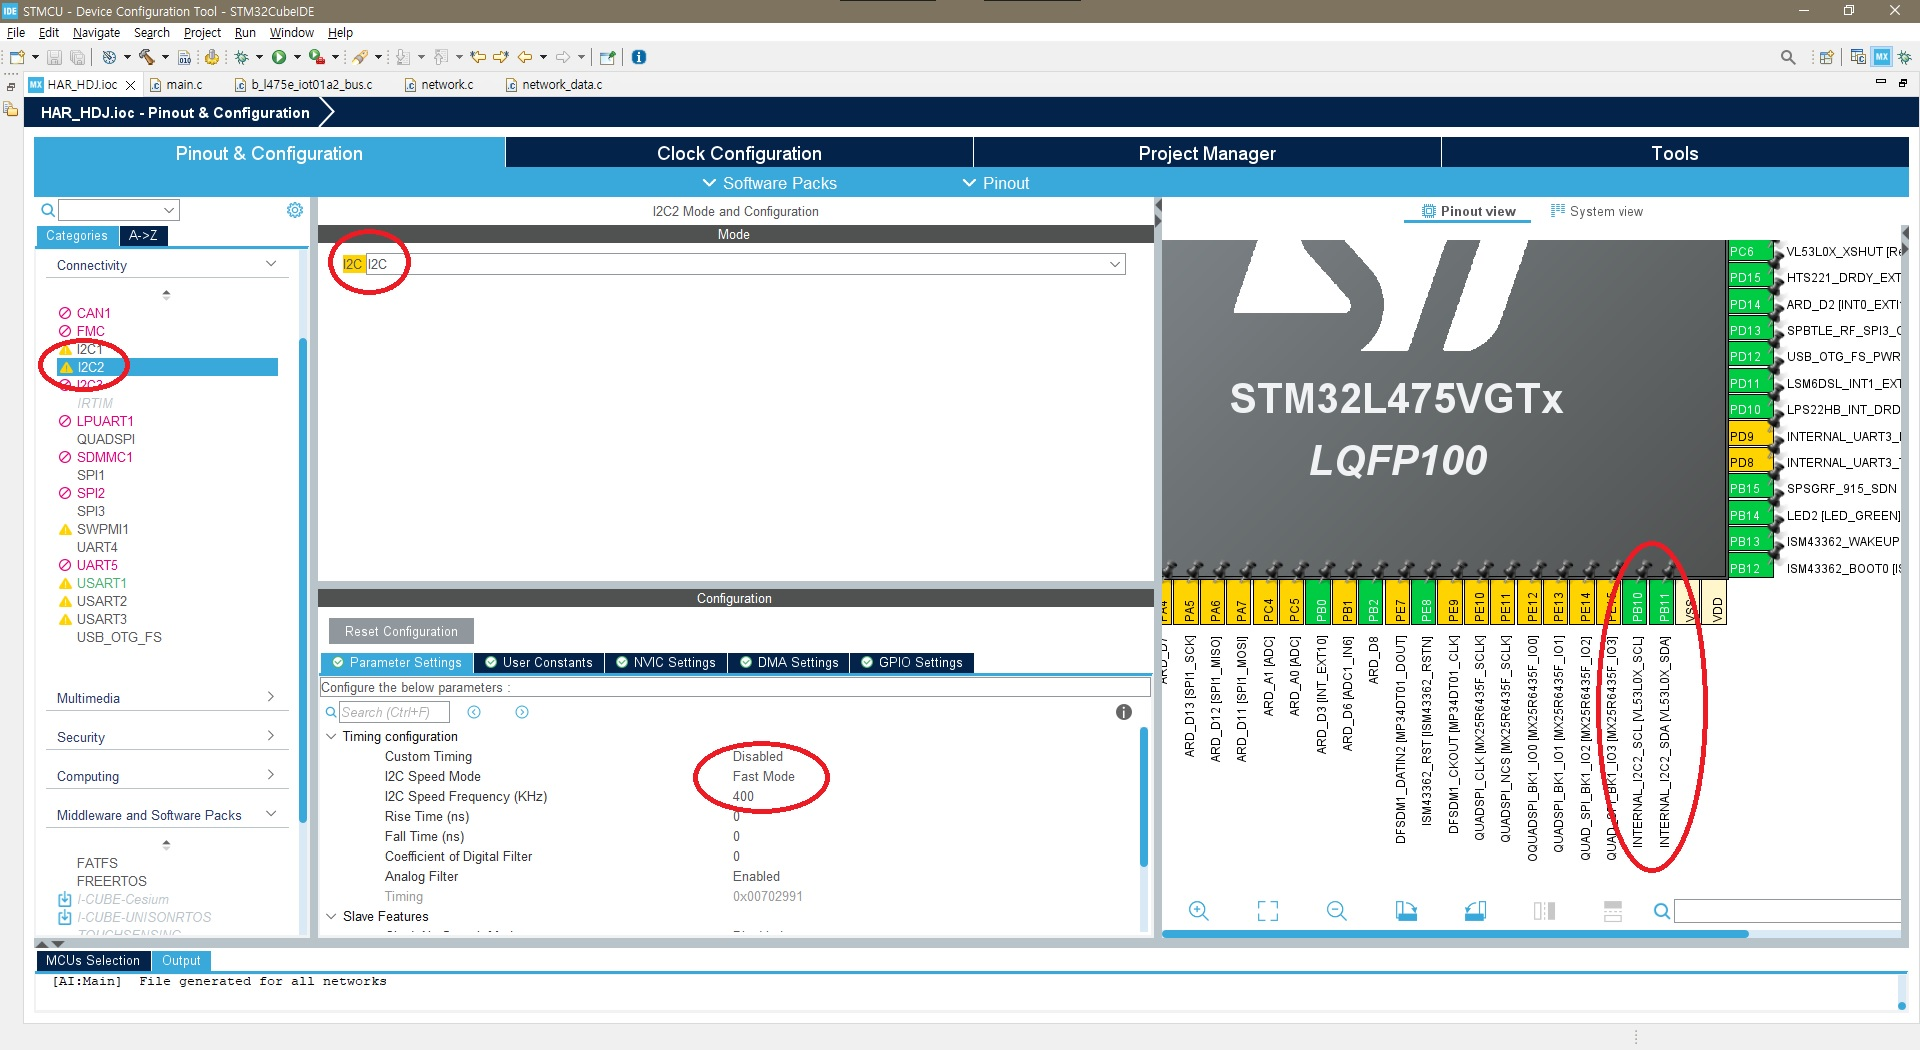

Configure the LSM6DSL interrupt line
- GPIO -> set PD11 to External Interrupt Mode with Rising edge trigger detection (EXTI_RISING)
- NVIC -> enable EXTI line[15:10] interrupts for EXTI11 interrupt.
-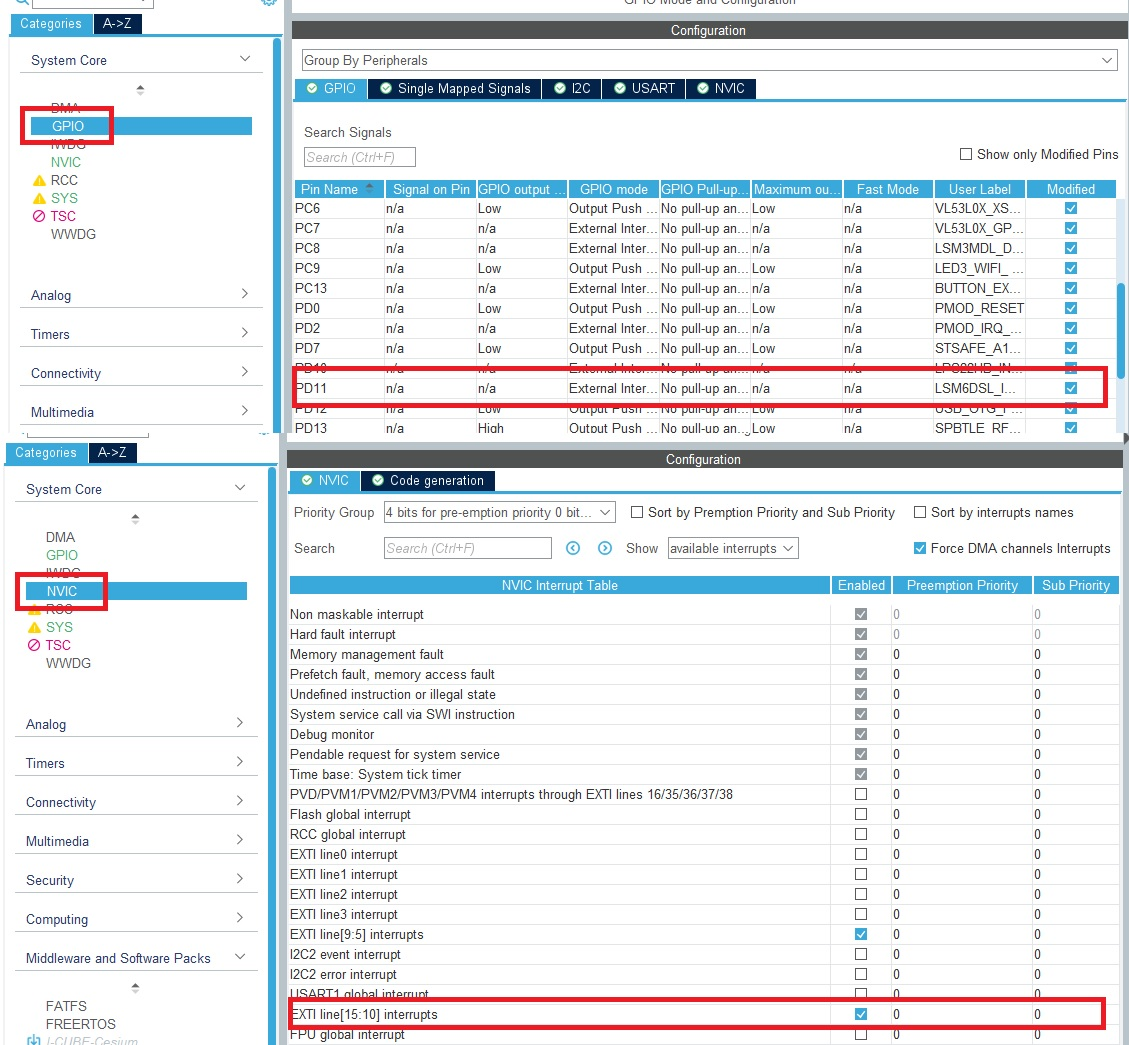

Configure the UART communication interface

USART1 -> Asynchronous -> Baud Rate to 115200 bit/s

GPIO Settings tab, ensure PB6 and PB7
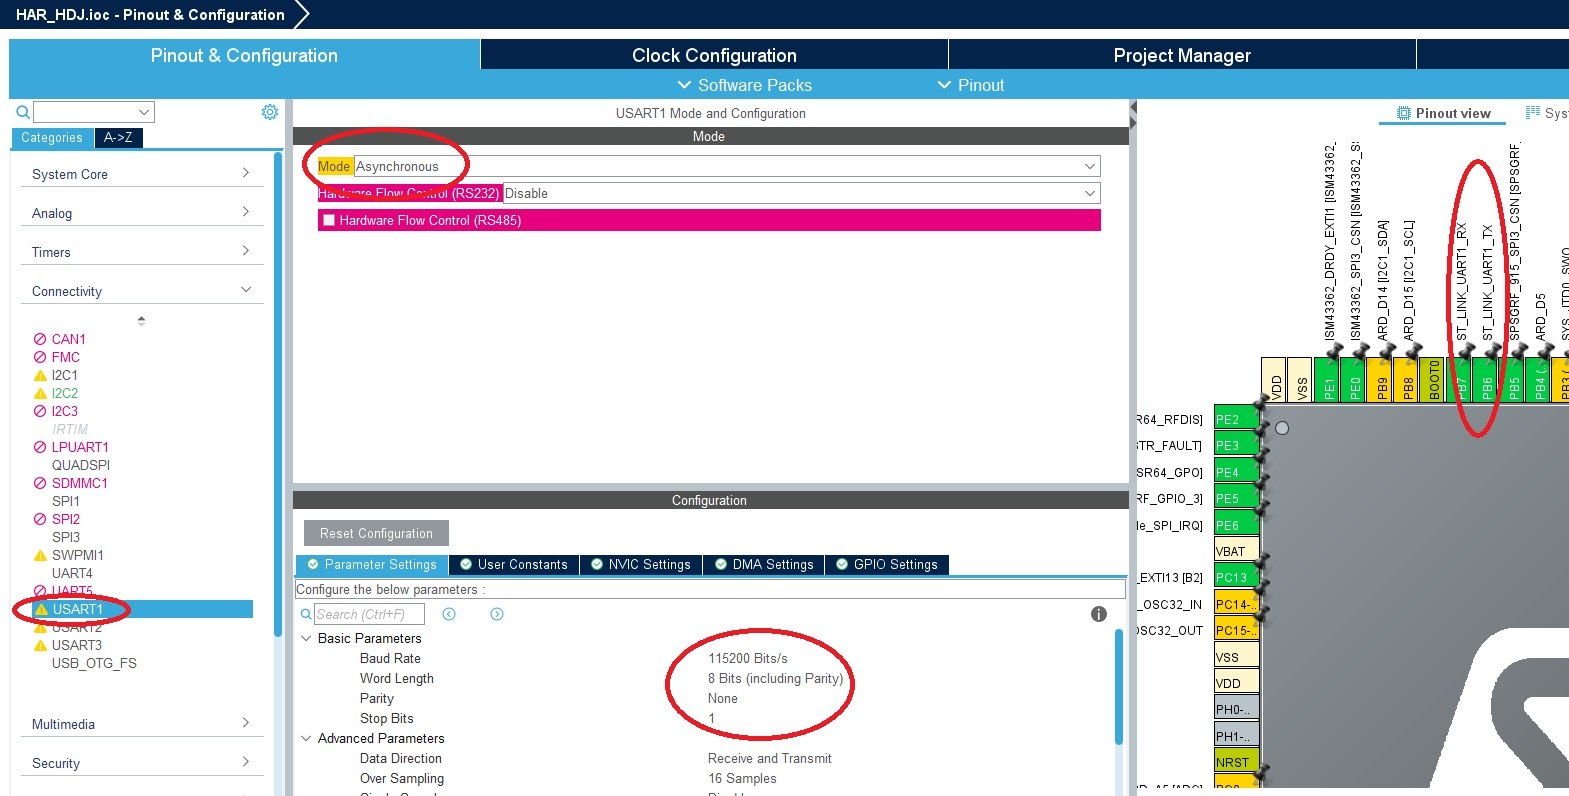

Generate code
- Project -> Generate Code

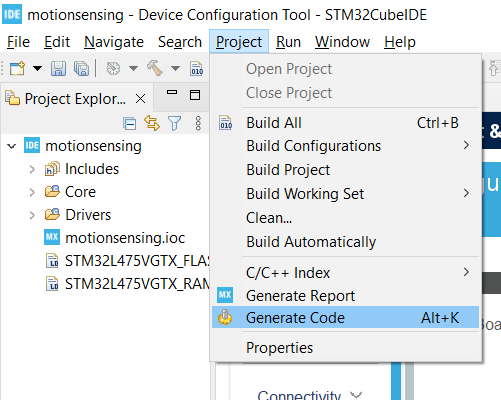

### main.c 에 코드 작성

1. Include headers for the LSM6DSL sensor
```c
/* USER CODE BEGIN Includes */
#include "lsm6dsl.h"
#include "b_l475e_iot01a1_bus.h"
#include <stdio.h>
/* USER CODE END Includes */
```

2. Create a global LSM6DSL motion sensor instance and data available status flag
```c
/* USER CODE BEGIN PV */
LSM6DSL_Object_t MotionSensor;
volatile uint32_t dataRdyIntReceived;
/* USER CODE END PV */
```

3. Define the MEMS_Init() function to configure the LSM6DSL motion sensor
```c
/* USER CODE BEGIN PFP */
static void MEMS_Init(void);
/* USER CODE END PFP */
```
```c
/* USER CODE BEGIN 4 */
static void MEMS_Init(void)
{
    LSM6DSL_IO_t io_ctx;
    uint8_t id;
    LSM6DSL_AxesRaw_t axes;

    /* Link I2C functions to the LSM6DSL driver */
    io_ctx.BusType     = LSM6DSL_I2C_BUS;
    io_ctx.Address     = LSM6DSL_I2C_ADD_L;
    io_ctx.Init        = BSP_I2C2_Init;
    io_ctx.DeInit      = BSP_I2C2_DeInit;
    io_ctx.ReadReg     = BSP_I2C2_ReadReg;
    io_ctx.WriteReg    = BSP_I2C2_WriteReg;
    io_ctx.GetTick     = BSP_GetTick;
    LSM6DSL_RegisterBusIO(&MotionSensor, &io_ctx);

    /* Read the LSM6DSL WHO_AM_I register */
    LSM6DSL_ReadID(&MotionSensor, &id);
    if (id != LSM6DSL_ID) {
    Error_Handler();
    }

    /* Initialize the LSM6DSL sensor */
    LSM6DSL_Init(&MotionSensor);

    /* Configure the LSM6DSL accelerometer (ODR, scale and interrupt) */
    LSM6DSL_ACC_SetOutputDataRate(&MotionSensor, 26.0f); /* 26 Hz */
    LSM6DSL_ACC_SetFullScale(&MotionSensor, 4);          /* [-4000mg; +4000mg] */
    LSM6DSL_ACC_Set_INT1_DRDY(&MotionSensor, ENABLE);    /* Enable DRDY */
    LSM6DSL_ACC_GetAxesRaw(&MotionSensor, &axes);        /* Clear DRDY */

    /* Start the LSM6DSL accelerometer */
    LSM6DSL_ACC_Enable(&MotionSensor);
}
/* USER CODE END 4 */
```

- 참고 : Use the following sequence to configure the LSM6DSL sensor to:
-- Range: ±4 g
-- Output Data Rate (ODR): 26 Hz
-- Linear acceleration sensitivity: 0.122 mg/LSB (FS = ±4)
-- Resolution: 16 bits (little endian by default)


4. Add a callback to the LSM6DSL sensor interrupt line (INT1 signal on GPIO PD11)
```c
/* USER CODE BEGIN 4 */
/*...*/
void HAL_GPIO_EXTI_Callback(uint16_t GPIO_Pin)
{
    if (GPIO_Pin == GPIO_PIN_11) {
        dataRdyIntReceived++;
    }
}
/* USER CODE END 4 */
```

5. Retarget printf to a UART serial port
```c
/*...*/
int _write(int fd, char * ptr, int len)
{
    HAL_UART_Transmit(&huart1, (uint8_t *) ptr, len, HAL_MAX_DELAY);
    return len;
}
/* USER CODE END 4 */
```

6. Implement an Error_Handler()
```c
void Error_Handler(void)
{
  /* USER CODE BEGIN Error_Handler_Debug */
  /* User can add his own implementation to report the HAL error return state */
#ifdef USE_IWDG_
	while(1)
	{
		HAL_GPIO_TogglePin(LED2_GPIO_Port, LED2_Pin);
		HAL_Delay(50); /* wait 50 ms */
	}
#else
	while(1)
	{
		HAL_GPIO_TogglePin(LED2_GPIO_Port, LED2_Pin);
		HAL_Delay(1000);
		HAL_NVIC_SystemReset();
	}
#endif
  /* USER CODE END Error_Handler_Debug */
}
```

7. Call the previously implemented MEMS_Init() function
```c
int main(void)
{
    /* ... */

    /* USER CODE BEGIN 2 */

    dataRdyIntReceived = 0;
    MEMS_Init();

    /* USER CODE END 2 */
}
```

8. Add code to read acceleration data
```c
int main(void)
{
  /* ... */

  /* Infinite loop */
  /* USER CODE BEGIN WHILE */
  while (1)
  {
    if (dataRdyIntReceived != 0) {
      dataRdyIntReceived = 0;
      LSM6DSL_Axes_t acc_axes;
      LSM6DSL_ACC_GetAxes(&MotionSensor, &acc_axes);
      printf("% 5d, % 5d, % 5d\r\n",  (int) acc_axes.x, (int) acc_axes.y, (int) acc_axes.z);
    }
    /* USER CODE END WHILE */

    /* USER CODE BEGIN 3 */
  }
  /* USER CODE END 3 */
}
```

### Compile, download and run
- 책상위에 움직이지 않고 평평하게 놓여 있을 경우 순선대로 x, y 는 0 에 가깝고 z 는 1g(1000) 에 가깝게 출력

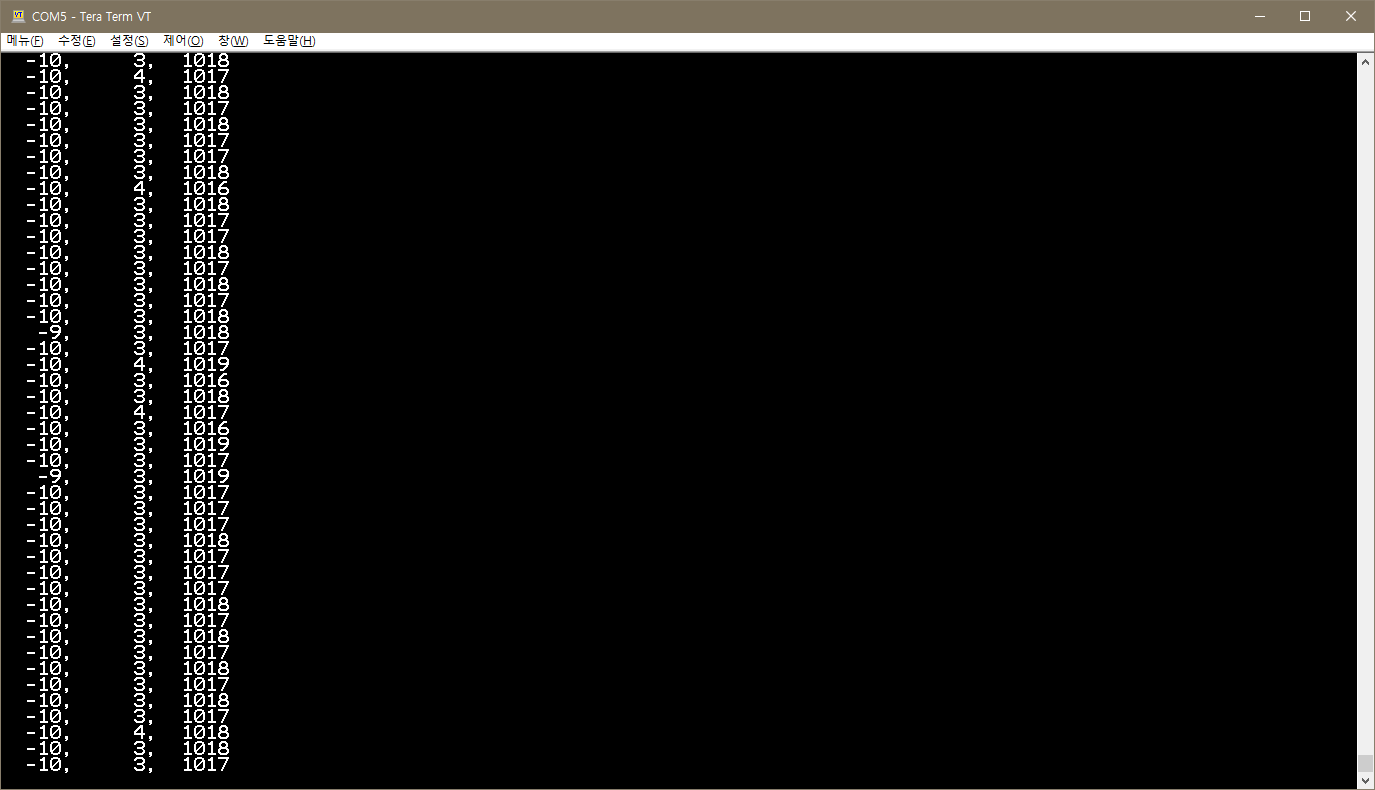


## Create an STM32Cube.AI application using X-CUBE-AI
- Create your model : 앞서 설명한 바와 같이 Human Activity Recognition.jpynb 를 colab 환경에서 실행 시켜 제공된 dataset 으로 학습 후 model.h5 를 생성 하였지만 MCU 코드로 add 시키는 과정의 analyze 에서 keras 버전이 맞지 않아 기존 model.h5 를 다운 받아 사용함 단 이는 optional 이기 때문에 위 생성된 모델을 사용하여도 될 것으로 보임

- (26, 3) shape 을 input 으로 받는 Conv1D 의 간단한 NN 모델로 activation 은 relu 를 사용하였으며 3개의 class 를 분류 하도록 최종 output 에 softmax 를 사용
- Dropout 을 사용하였으며 Flatten 을 거쳐 최종 3개 확률값을 output 으로 출력 
- optimizer 는 adam 을 사용하였고 loss 는 label 이 one-hot -encoding 형태가 아니기 때문에 sparse_categorical_crossentropy 사용

```python
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(26, 3)),
  tf.keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=30)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print("Test loss:", test_loss)
print("Test acc:", test_acc)
```
```
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 conv1d (Conv1D)             (None, 24, 16)            160       
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 8)             392       
                                                                 
 dropout (Dropout)           (None, 22, 8)             0         
                                                                 
 flatten (Flatten)           (None, 176)               0         
                                                                 
 dense (Dense)               (None, 64)                11328     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
=================================================================
Total params: 12,075
Trainable params: 12,075
Non-trainable params: 0
_________________________________________________________________
```

- train 시 epoch=30 최종 결과는 아래와 같으며 test set 의 정확도는 0.99
```
Epoch 30/30
162/162 [==============================] - 1s 3ms/step - loss: 0.0283 - accuracy: 0.9927
54/54 - 0s - loss: 0.0378 - accuracy: 0.9913 - 290ms/epoch - 5ms/step
Test loss: 0.03783567249774933
Test acc: 0.991304337978363
```

### Add STM32Cube.AI to your project
- Select Components -> Artificial Intelligence 체크 -> Core 체크 -> Ok

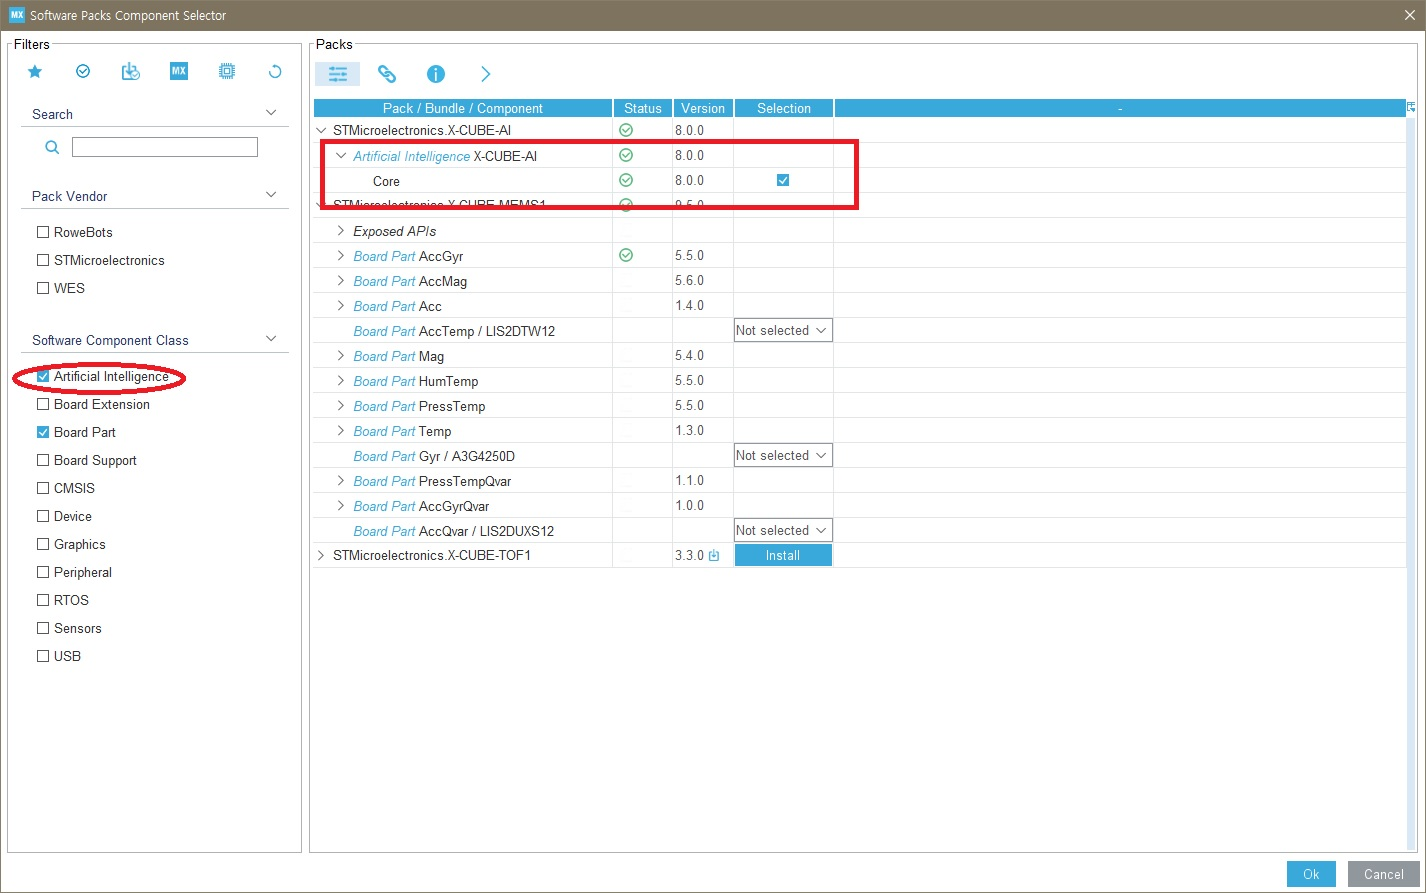

#### configure the X-CUBE-AI component to use your keras model
1. Expand Additional Software to select STMicroelectronics.X-CUBE-AI
2. Check to make sure the X-CUBE-AI component is selected
3. Click Add network
4. Change the Network Type to Keras
5. Browse to select the model
6. (optional) Click on Analyze to view the model memory footprint, occupation and complexity.
7. Save or Project > Generate Code

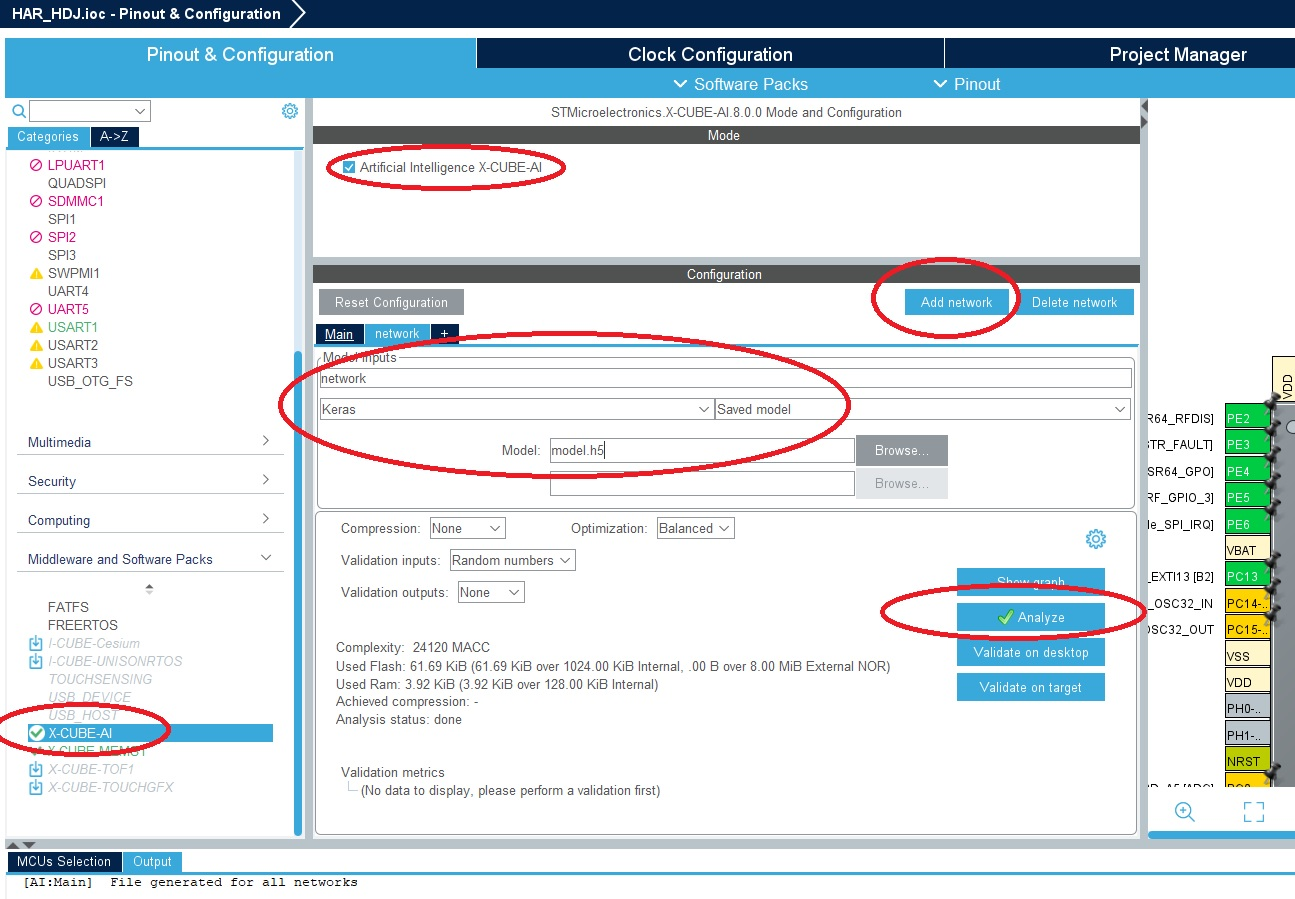

### main.c 에서 코드 작성

- Include headers for STM32Cube.AI
```c
/* Private includes ----------------------------------------------------------*/
/* USER CODE BEGIN Includes */
#include "lsm6dsl.h"
#include "b_l475e_iot01a1_bus.h"
#include "ai_platform.h"
#include "network.h"
#include "network_data.h"
#include <stdio.h>
/* USER CODE END Includes */
```

- Declare neural-network buffers
```c
/* USER CODE BEGIN PV */
LSM6DSL_Object_t MotionSensor;
volatile uint32_t dataRdyIntReceived;
ai_handle network;
float aiInData[AI_NETWORK_IN_1_SIZE];
float aiOutData[AI_NETWORK_OUT_1_SIZE];
ai_u8 activations[AI_NETWORK_DATA_ACTIVATIONS_SIZE];
const char* activities[AI_NETWORK_OUT_1_SIZE] = {
  "stationary", "walking", "running"
};
ai_buffer * ai_input;
ai_buffer * ai_output;
/* USER CODE END PV */
```
-- 참고 : With default generation options, three additional buffers should be allocated: the activations, input and output buffers. The activations buffer is private memory space for the CubeAI runtime. During the execution of the inference, it is used to store intermediate results. Declare a neural-network input and output buffer (aiInData and aiOutData). The corresponding output labels must also be added to activities.

- Add AI bootstrapping functions
```c
/* Private function prototypes -----------------------------------------------*/
void SystemClock_Config(void);
static void MX_GPIO_Init(void);
static void MX_USART1_UART_Init(void);
static void MX_CRC_Init(void);
/* USER CODE BEGIN PFP */
static void MEMS_Init(void);
static void AI_Init(void);
static void AI_Run(float *pIn, float *pOut);
static uint32_t argmax(const float * values, uint32_t len);
/* USER CODE END PFP */
```
```c
/* USER CODE BEGIN 4 */
/*...*/
static void AI_Init(void)
{
  ai_error err;

  /* Create a local array with the addresses of the activations buffers */
  const ai_handle act_addr[] = { activations };
  /* Create an instance of the model */
  err = ai_network_create_and_init(&network, act_addr, NULL);
  if (err.type != AI_ERROR_NONE) {
    printf("ai_network_create error - type=%d code=%d\r\n", err.type, err.code);
    Error_Handler();
  }
  ai_input = ai_network_inputs_get(network, NULL);
  ai_output = ai_network_outputs_get(network, NULL);
}
```
```c
static void AI_Run(float *pIn, float *pOut)
{
  ai_i32 batch;
  ai_error err;

  /* Update IO handlers with the data payload */
  ai_input[0].data = AI_HANDLE_PTR(pIn);
  ai_output[0].data = AI_HANDLE_PTR(pOut);

  batch = ai_network_run(network, ai_input, ai_output);
  if (batch != 1) {
    err = ai_network_get_error(network);
    printf("AI ai_network_run error - type=%d code=%d\r\n", err.type, err.code);
    Error_Handler();
  }
}
/* USER CODE END 4 */
```

- Create an argmax function
```c
/* USER CODE BEGIN 4 */
/*...*/
static uint32_t argmax(const float * values, uint32_t len)
{
  float max_value = values[0];
  uint32_t max_index = 0;
  for (uint32_t i = 1; i < len; i++) {
    if (values[i] > max_value) {
      max_value = values[i];
      max_index = i;
    }
  }
  return max_index;
}
/* USER CODE END 4 */
```

- Call the previously implemented AI_Init() function
```c
int main(void)
{
  /* ... */

  /* USER CODE BEGIN 2 */

  dataRdyIntReceived = 0;
  MEMS_Init();
  AI_Init();

  /* USER CODE END 2 */
```

- Update the main while loop
```c
/* Infinite loop */
  /* USER CODE BEGIN WHILE */
  uint32_t write_index = 0;
  while (1)
  {
    if (dataRdyIntReceived != 0) {
      dataRdyIntReceived = 0;
      LSM6DSL_Axes_t acc_axes;
      LSM6DSL_ACC_GetAxes(&MotionSensor, &acc_axes);
      // printf("% 5d, % 5d, % 5d\r\n",  (int) acc_axes.x, (int) acc_axes.y, (int) acc_axes.z);

      /* Normalize data to [-1; 1] and accumulate into input buffer */
      /* Note: window overlapping can be managed here */
      aiInData[write_index + 0] = (float) acc_axes.x / 4000.0f;
      aiInData[write_index + 1] = (float) acc_axes.y / 4000.0f;
      aiInData[write_index + 2] = (float) acc_axes.z / 4000.0f;
      write_index += 3;

      if (write_index == AI_NETWORK_IN_1_SIZE) {
        write_index = 0;

        printf("Running inference\r\n");
        AI_Run(aiInData, aiOutData);

        /* Output results */
        for (uint32_t i = 0; i < AI_NETWORK_OUT_1_SIZE; i++) {
          printf("%8.6f ", aiOutData[i]);
        }
        uint32_t class = argmax(aiOutData, AI_NETWORK_OUT_1_SIZE);
        printf(": %d - %s\r\n", (int) class, activities[class]);
      }
    }
    /* USER CODE END WHILE */

    /* USER CODE BEGIN 3 */
  }
  /* USER CODE END 3 */
}
```

- Enable float with printf in the build settings

-- When using GCC and Newlib-nano, formatted input/output of floating-point number are implemented as weak symbol. If you want to use %f, you have to pull in the symbol by explicitly specifying -u _printf_float command option in the GCC Linker flags. This option can be added to the project build settings:

Open the project properties in Project > Properties.
Expand C/++ Build and go to Settings.
Under the Tool Settings tab, enable Use float with printf from newlib-nano (-u _printf_float).

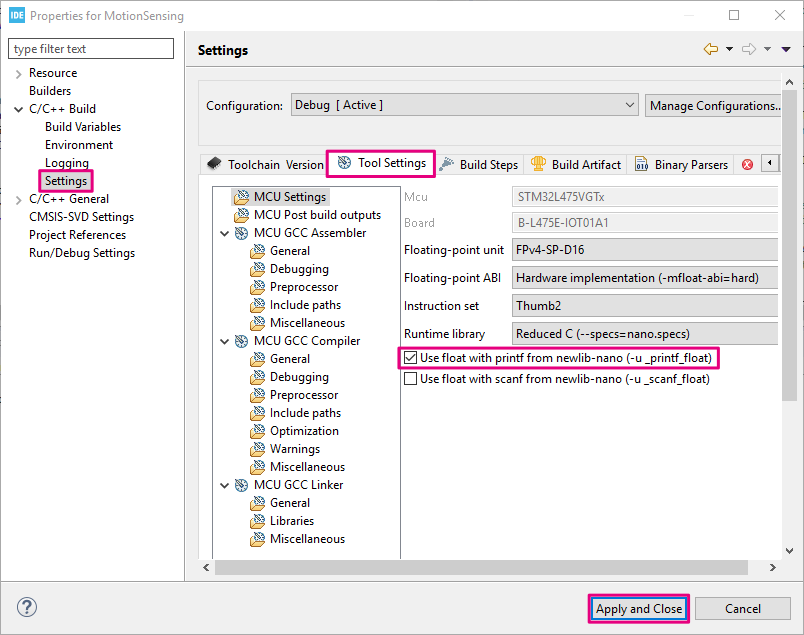

### Compile, download and run
보드에 F/W 업로드 후 Tera Term 에서 아래와 같은 log 확인 가능
학습된 모델을 통해 실시간 센서값을 받아 inference 하며 아래와 같이 동작됨을 확인
- 보드를 움직이지 않을 경우 "stationary"
- 아래 위로 살짝살짝 흔드는 경우 "walking"
- 빠르게 아래 위로 흔드는 경우 "running"

youtube: [시연영상][ylink]  
 
[ylink]: https://youtube.com/shorts/BbotUSGTH7s?feature=share

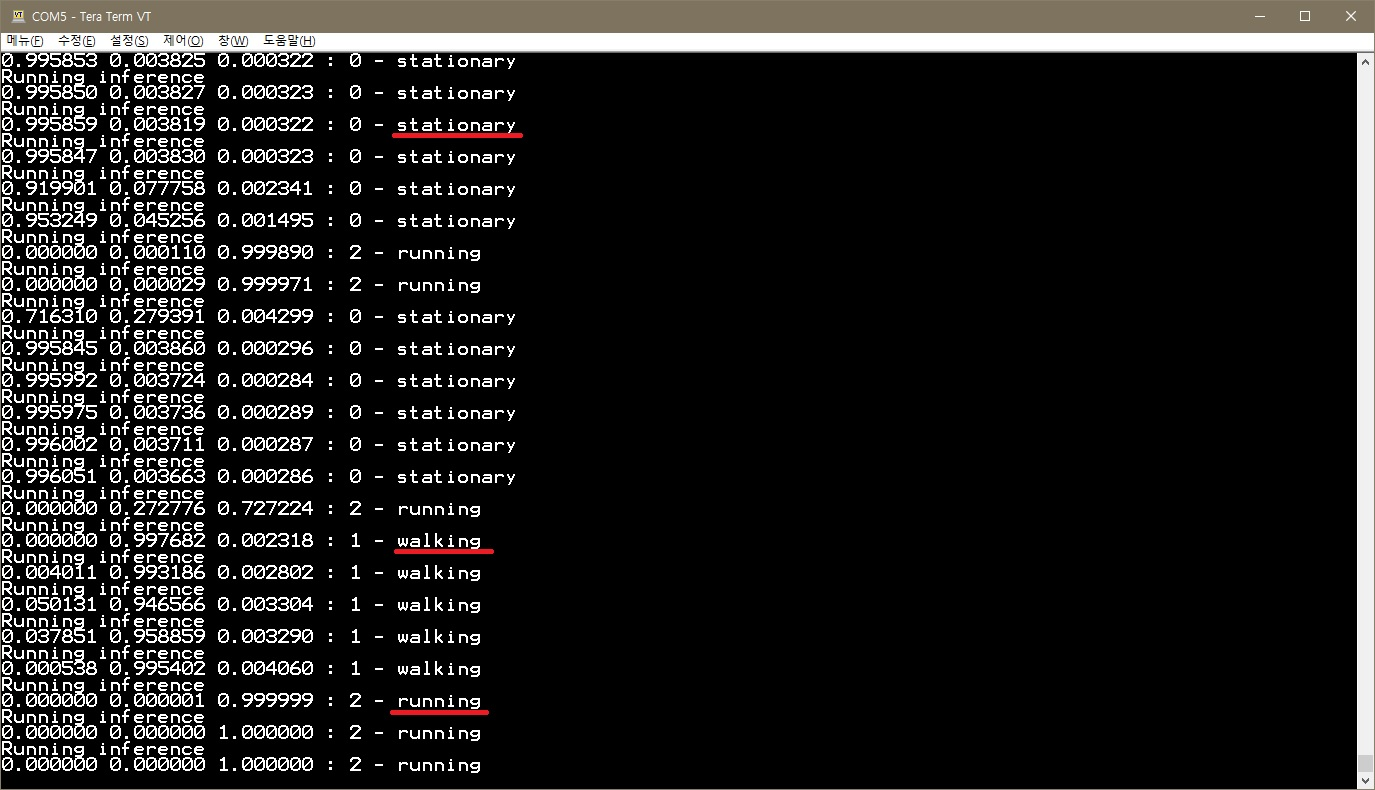